In [1]:
import pandas as pd
import pickle
import os
import math
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt
# import arviz
# import pystan
import random
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture

from scipy.spatial import cKDTree as KDTree
from scipy.stats import multivariate_normal, gaussian_kde, entropy, gamma
# from fastkde import fastKDE
# from entropy_estimators import continuous
# import seaborn as sns
from tqdm.auto import tqdm
# import seaborn as sns

import os
from cmdstanpy.model import CmdStanModel
from cmdstanpy.utils import cmdstan_path

import arviz as az

# Build Stan Model

In [35]:
# whether to recompile the stan program
DO_COMPILE = True

# simple noise or prior on noise
SIMPLE_NOISE = True

# stan program path
if SIMPLE_NOISE:
    stan_path = 'multi_feature_simple_noise.stan'
    pkl_file = 'model_simple_noise.pkl'
else:
    stan_path = 'multi_feature.stan'
    pkl_file = 'model.pkl'

model = CmdStanModel(stan_file='multi_feature_better_noise.stan')

In [36]:
# mu
mu_mean = 0
mu_sd = 0.5

# sd
sigma_alpha = 2
sigma_beta = 2

#noise parameters
noise_alpha = 7.5
noise_beta = 1


# lower bound of sigma prior
lower_sigma_bound = 0.1

# noise SD prior
epsilon_alpha = 1
epsilon_beta = 1

# for simple noise 
noise = 0.4

# environmental EIG
env_info = 0.01

In [42]:
# number of stimuli
sequence_length = 6

# number of features 
num_features = 1

# number of samples (max)
num_samples = 3000

# allocation of samples to exemplars
exemplar_idx = np.repeat(np.arange(1, sequence_length+1), num_samples/sequence_length)


# background / deviant mean values
background = np.repeat(1, num_features)
deviant = np.repeat(3, num_features)

# perceptual noise
sig = np.identity(num_features) * 0.001;

# deviant position
deviant_pos = 6

# stimulus means
exemplar_means = np.tile(background, (sequence_length, 1))
exemplar_means[deviant_pos-1] = deviant

In [43]:
# number of iterations and warmup per model run
num_iter = 20000 # num of samples for MCMC and VI
num_warmup = 4000

# number of total model runs
num_model_runs = 5

# how much to thin posteriors (value determines how we "retain every nth sample")
thinning_factor = 1

In [44]:
data = {"mu_mean": mu_mean , "mu_sd": mu_sd, "sigma_alpha": sigma_alpha, "sigma_beta": sigma_beta, 
"epsilon_alpha": epsilon_alpha, "epsilon_beta": epsilon_beta, "noise": noise, "F": num_features, 'noise_alpha': noise_alpha, 'noise_beta':noise_beta}

In [45]:

# generate the data
sim_data = [np.random.multivariate_normal(exemplar_means[idx-1], sig) for idx in exemplar_idx] 
sim_data = np.asmatrix(sim_data)

# Iterators
samples_from_current_stim = 1
total_samples = 1
exemplar_num = 1

# initialize data
sample_data = np.empty((num_samples,num_features))
sample_data[:] = np.nan

exemplar_labels = np.empty((num_samples,))
exemplar_labels[:] = np.nan

In [46]:
print('stimulus: ', exemplar_num)
        
print('sample: ', total_samples)


# sample number
data["M"] = total_samples

# exemplar number 
data["K"] = exemplar_num

# add sim data
sample_data[total_samples-1] = sim_data[exemplar_idx == exemplar_num][samples_from_current_stim-1]
data["z"] = np.transpose(sample_data[0:total_samples,:])

# add exemplar for each id
exemplar_labels[total_samples-1] = int(exemplar_num)
data["exemplar_idx"] = [int(x) for x in exemplar_labels[~np.isnan(exemplar_labels)]]

# get posterior samples
# fit = sm.sampling(data=data, iter=num_iter, chains=1, warmup = num_warmup,control=dict(adapt_delta=0.95)); # TODO


# posterior = np.hstack((fit['mu'][0:len(fit['mu']):thinning_factor], \
#                        fit['sigma'][0:len(fit['mu']):thinning_factor])) # TODO



stimulus:  1
sample:  1


# Run VI with multiple seeds

In [ ]:
parameter_estimates = {'mu[1]': [], 'sigma[1]': []}

for i in range(100):
  vi = model.variational(data=data, output_samples=1000, iter=100000, seed=np.random.randint(2**32), require_converged=False)

  parameter_estimates['mu[1]'].append(vi.variational_params_dict['mu[1]'])

  parameter_estimates['sigma[1]'].append((vi.variational_params_dict['sigma[1]']))

# print(parameter_estimates['mu[1]'])


  

In [ ]:
plt.hist(parameter_estimates['mu[1]'], bins=10)
plt.xlabel('VI mu estimate')
plt.ylabel('frequency')
plt.show

# MCMC 100 chains estimation

In [22]:
mcmc_fit = model.sample(data=data, chains=10)

12:53:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 5 |          | 00:00 Status

chain 6 |          | 00:00 Status

chain 7 |          | 00:00 Status

chain 8 |          | 00:00 Status

chain 9 |          | 00:00 Status

chain 10 |          | 00:00 Status

12:53:41 - cmdstanpy - ERROR - Chain [4] error: error during processing Operation not permitted
12:53:41 - cmdstanpy - ERROR - Chain [2] error: error during processing Operation not permitted
12:53:41 - cmdstanpy - ERROR - Chain [3] error: error during processing Operation not permitted
12:53:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
12:53:41 - cmdstanpy - ERROR - Chain [5] error: error during processing Operation not permitted
12:53:41 - cmdstanpy - ERROR - Chain [6] error: error during processing Operation not permitted
12:53:41 - cmdstanpy - ERROR - Chain [8] error: error during processing Operation not permitted
12:53:41 - cmdstanpy - ERROR - Chain [7] error: error during processing Operation not permitted
12:53:41 - cmdstanpy - ERROR - Chain [9] error: error during processing Operation not permitted
12:53:41 - cmdstanpy - ERROR - Chain [10] error: error during processing Operation not permitted


12:53:41 - cmdstanpy - INFO - CmdStan done processing.


RuntimeError: Error during sampling:
Exception: mismatch in dimension declared and found in context; processing stage=data initialization; variable name=z; position=1; dims declared=(1,1); dims found=(1,10) (in '/Users/mrnoodle/Desktop/baby_attention/PPL_attempts/stan/multi_feature_better_noise.stan', line 5, column 4 to column 19)
Exception: mismatch in dimension declared and found in context; processing stage=data initialization; variable name=z; position=1; dims declared=(1,1); dims found=(1,10) (in '/Users/mrnoodle/Desktop/baby_attention/PPL_attempts/stan/multi_feature_better_noise.stan', line 5, column 4 to column 19)
Exception: mismatch in dimension declared and found in context; processing stage=data initialization; variable name=z; position=1; dims declared=(1,1); dims found=(1,10) (in '/Users/mrnoodle/Desktop/baby_attention/PPL_attempts/stan/multi_feature_better_noise.stan', line 5, column 4 to column 19)
Exception: mismatch in dimension declared and found in context; processing stage=data initialization; variable name=z; position=1; dims declared=(1,1); dims found=(1,10) (in '/Users/mrnoodle/Desktop/baby_attention/PPL_attempts/stan/multi_feature_better_noise.stan', line 5, column 4 to column 19)
Exception: mismatch in dimension declared and found in context; processing stage=data initialization; variable name=z; position=1; dims declared=(1,1); dims found=(1,10) (in '/Users/mrnoodle/Desktop/baby_attention/PPL_attempts/stan/multi_feature_better_noise.stan', line 5, column 4 to column 19)
Exception: mismatch in dimension declared and found in context; processing stage=data initialization; variable name=z; position=1; dims declared=(1,1); dims found=(1,10) (in '/Users/mrnoodle/Desktop/baby_attention/PPL_attempts/stan/multi_feature_better_noise.stan', line 5, column 4 to column 19)
Exception: mismatch in dimension declared and found in context; processing stage=data initialization; variable name=z; position=1; dims declared=(1,1); dims found=(1,10) (in '/Users/mrnoodle/Desktop/baby_attention/PPL_attempts/stan/multi_feature_better_noise.stan', line 5, column 4 to column 19)
Exception: mismatch in dimension declared and found in context; processing stage=data initialization; variable name=z; position=1; dims declared=(1,1); dims found=(1,10) (in '/Users/mrnoodle/Desktop/baby_attention/PPL_attempts/stan/multi_feature_better_noise.stan', line 5, column 4 to column 19)
Exception: mismatch in dimension declared and found in context; processing stage=data initialization; variable name=z; position=1; dims declared=(1,1); dims found=(1,10) (in '/Users/mrnoodle/Desktop/baby_attention/PPL_attempts/stan/multi_feature_better_noise.stan', line 5, column 4 to column 19)
Exception: mismatch in dimension declared and found in context; processing stage=data initialization; variable name=z; position=1; dims declared=(1,1); dims found=(1,10) (in '/Users/mrnoodle/Desktop/baby_attention/PPL_attempts/stan/multi_feature_better_noise.stan', line 5, column 4 to column 19)
Command and output files:
RunSet: chains=10, chain_ids=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], num_processes=10
 cmd (chain 1):
	['/Users/mrnoodle/Desktop/baby_attention/PPL_attempts/stan/multi_feature_better_noise', 'id=1', 'random', 'seed=12', 'data', 'file=/var/folders/nr/_mmdkbk13zq4wqd30h87r_6m0000gn/T/tmpif_w11y5/ronl9nau.json', 'output', 'file=/var/folders/nr/_mmdkbk13zq4wqd30h87r_6m0000gn/T/tmpif_w11y5/multi_feature_better_noisecc479unr/multi_feature_better_noise-20221126125341_1.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 per-chain output files (showing chain 1 only):
 csv_file:
	/var/folders/nr/_mmdkbk13zq4wqd30h87r_6m0000gn/T/tmpif_w11y5/multi_feature_better_noisecc479unr/multi_feature_better_noise-20221126125341_1.csv
 console_msgs (if any):
	/var/folders/nr/_mmdkbk13zq4wqd30h87r_6m0000gn/T/tmpif_w11y5/multi_feature_better_noisecc479unr/multi_feature_better_noise-20221126125341_0-stdout.txt
Consider re-running with show_console=True if the above output is unclear!

In [ ]:
mcmc_mu_estimates = mcmc_fit.draws()[:, :, 7]

In [ ]:
mcmc_mu_estimates.shape # [estimate index, chain index]

In [ ]:
mcmc_mu_chain_means = np.mean(mcmc_mu_estimates, axis=0)

## Plot

In [ ]:
plt.hist(mcmc_mu_chain_means, bins=10)
plt.xlabel('mcmc mu estimates (chain average, 100 chains)')
plt.ylabel('frequency')

# MCMC 100 iterations with single chain

In [ ]:
single_chain_averages = []
for i in range(100): #this seems to be slower than running 100 chains at once
  mcmc_fit_single_chain = model.sample(data=data, chains=1)
  mu_estimates = mcmc_fit_single_chain.draws()[:, :, 7]
  single_chain_averages.append(np.mean(mu_estimates, axis=0))


# Histogram

In [ ]:
plt.hist(np.array(single_chain_averages), bins=10)
plt.xlabel('mcmc mu estimates (per chain average, 100 single chain iterations)')
plt.ylabel('frequency')

# MCMC Single Chain Running Average

In [24]:
single_chain_averages = []

mcmc_fit_single_chain = model.sample(data=data, chains=1)
mu_estimates = mcmc_fit_single_chain.draws()[:, :, 7]
# single_chain_averages.append(np.mean(mu_estimates, axis=0))

cumulative_sums = np.cumsum(mu_estimates[:, 0], axis=0)

14:15:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:15:06 - cmdstanpy - INFO - CmdStan done processing.
14:15:06 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 22 divergent transitions (2.2%)
	Use function "diagnose()" to see further information.


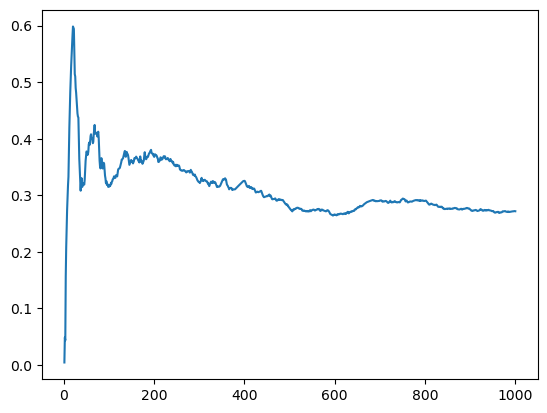

In [26]:
time_steps = np.arange(1, len(cumulative_sums) + 1)

cumulative_means = cumulative_sums / time_steps

plt.plot(time_steps, cumulative_means)


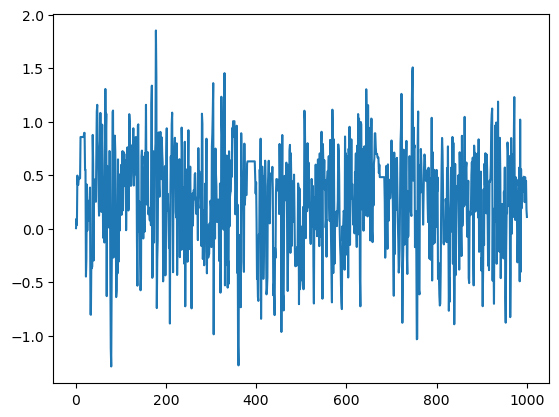

In [28]:
plt.plot(time_steps, mu_estimates)

# Generate data from attention model

In [55]:

gamma_noise = np.random.gamma(noise_alpha, 1 / noise_beta) #np gamma uses theta = 1/beta as the second parameter
mu = np.random.normal(mu_mean, mu_sd)
sigma = np.random.gamma(sigma_alpha, 1 / sigma_beta)
y = np.random.normal(mu, sigma)
z = np.random.normal(y, gamma_noise, (1, 100))

In [56]:
z

array([[ 12.04059521,   4.28411665,   5.37562414,   9.04286881,
        -27.81383606,  16.35205702,  12.07169204,   1.47491958,
         -1.67313829, -13.40060734,   6.90245653, -17.96108686,
          7.55880986,  -3.1625278 ,   3.41804377,   6.5769556 ,
          9.16754032, -14.49968407,   8.5497718 ,   8.91423087,
        -17.01714761,  -7.72853999, -22.23151803,  -1.78548453,
         -7.12700148,   4.65042273,   5.64358195,  -5.79494277,
         -0.95057373,  13.17070967,  13.94140583,   2.31983022,
          3.51671856,   2.40548598,  19.42758938,   1.13225643,
         18.06612036,   8.81494959,  12.22425207,   5.9873776 ,
         -8.97844716,   0.73267338,  -5.9388957 ,   5.76445502,
          0.56692073,  -3.81592102,  -0.5803326 ,   3.41437485,
          8.03720822,  -3.23394569,  -9.82374953,   5.76618702,
          5.82312514,  17.76414461,  -5.65502149,   2.48684353,
         -8.04455403,  -8.77828119,   3.24913162,  13.84569968,
         -4.70535268, -15.36711273,  -1.

In [57]:
data['z'] = z

In [58]:
data['exemplar_idx'] = np.ones(100, dtype=int)
data['M'] = 100

In [60]:
mcmc_fit = model.sample(data=data, chains=10)

14:18:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 5 |          | 00:00 Status

chain 6 |          | 00:00 Status

chain 7 |          | 00:00 Status

chain 8 |          | 00:00 Status

chain 9 |          | 00:00 Status

chain 10 |          | 00:00 Status

14:18:44 - cmdstanpy - INFO - CmdStan done processing.
14:18:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/Users/mrnoodle/Desktop/baby_attention/PPL_attempts/stan/multi_feature_better_noise.stan', line 29, column 4 to column 43)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/Users/mrnoodle/Desktop/baby_attention/PPL_attempts/stan/multi_feature_better_noise.stan', line 29, column 4 to column 43)
Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/Users/mrnoodle/Desktop/baby_attention/PPL_attempts/stan/multi_feature_better_noise.stan', line 29, column 4 to column 43)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/Users/mrnoodle/Desktop/baby_attention/PPL_attempts/stan/multi_feature_better_noise.stan', line 29, column 4 to column 43)
	Exception: gamma_lpdf: Random variable is inf, but must be p

# Make arviz pair plots

In [62]:
cmdstanpy_data = az.from_cmdstanpy(
    posterior=mcmc_fit
)

array([[<AxesSubplot: ylabel='mu\n0'>, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: ylabel='sigma\n0'>, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: ylabel='y\n0, 0'>, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: ylabel='noise'>, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: xlabel='mu\n0', ylabel='z_rep\n0'>,
        <AxesSubplot: xlabel='sigma\n0'>,
        <AxesSubplot: xlabel='y\n0, 0'>, <AxesSubplot: xlabel='noise'>,
        <AxesSubplot: xlabel='z_rep\n0'>]], dtype=object)

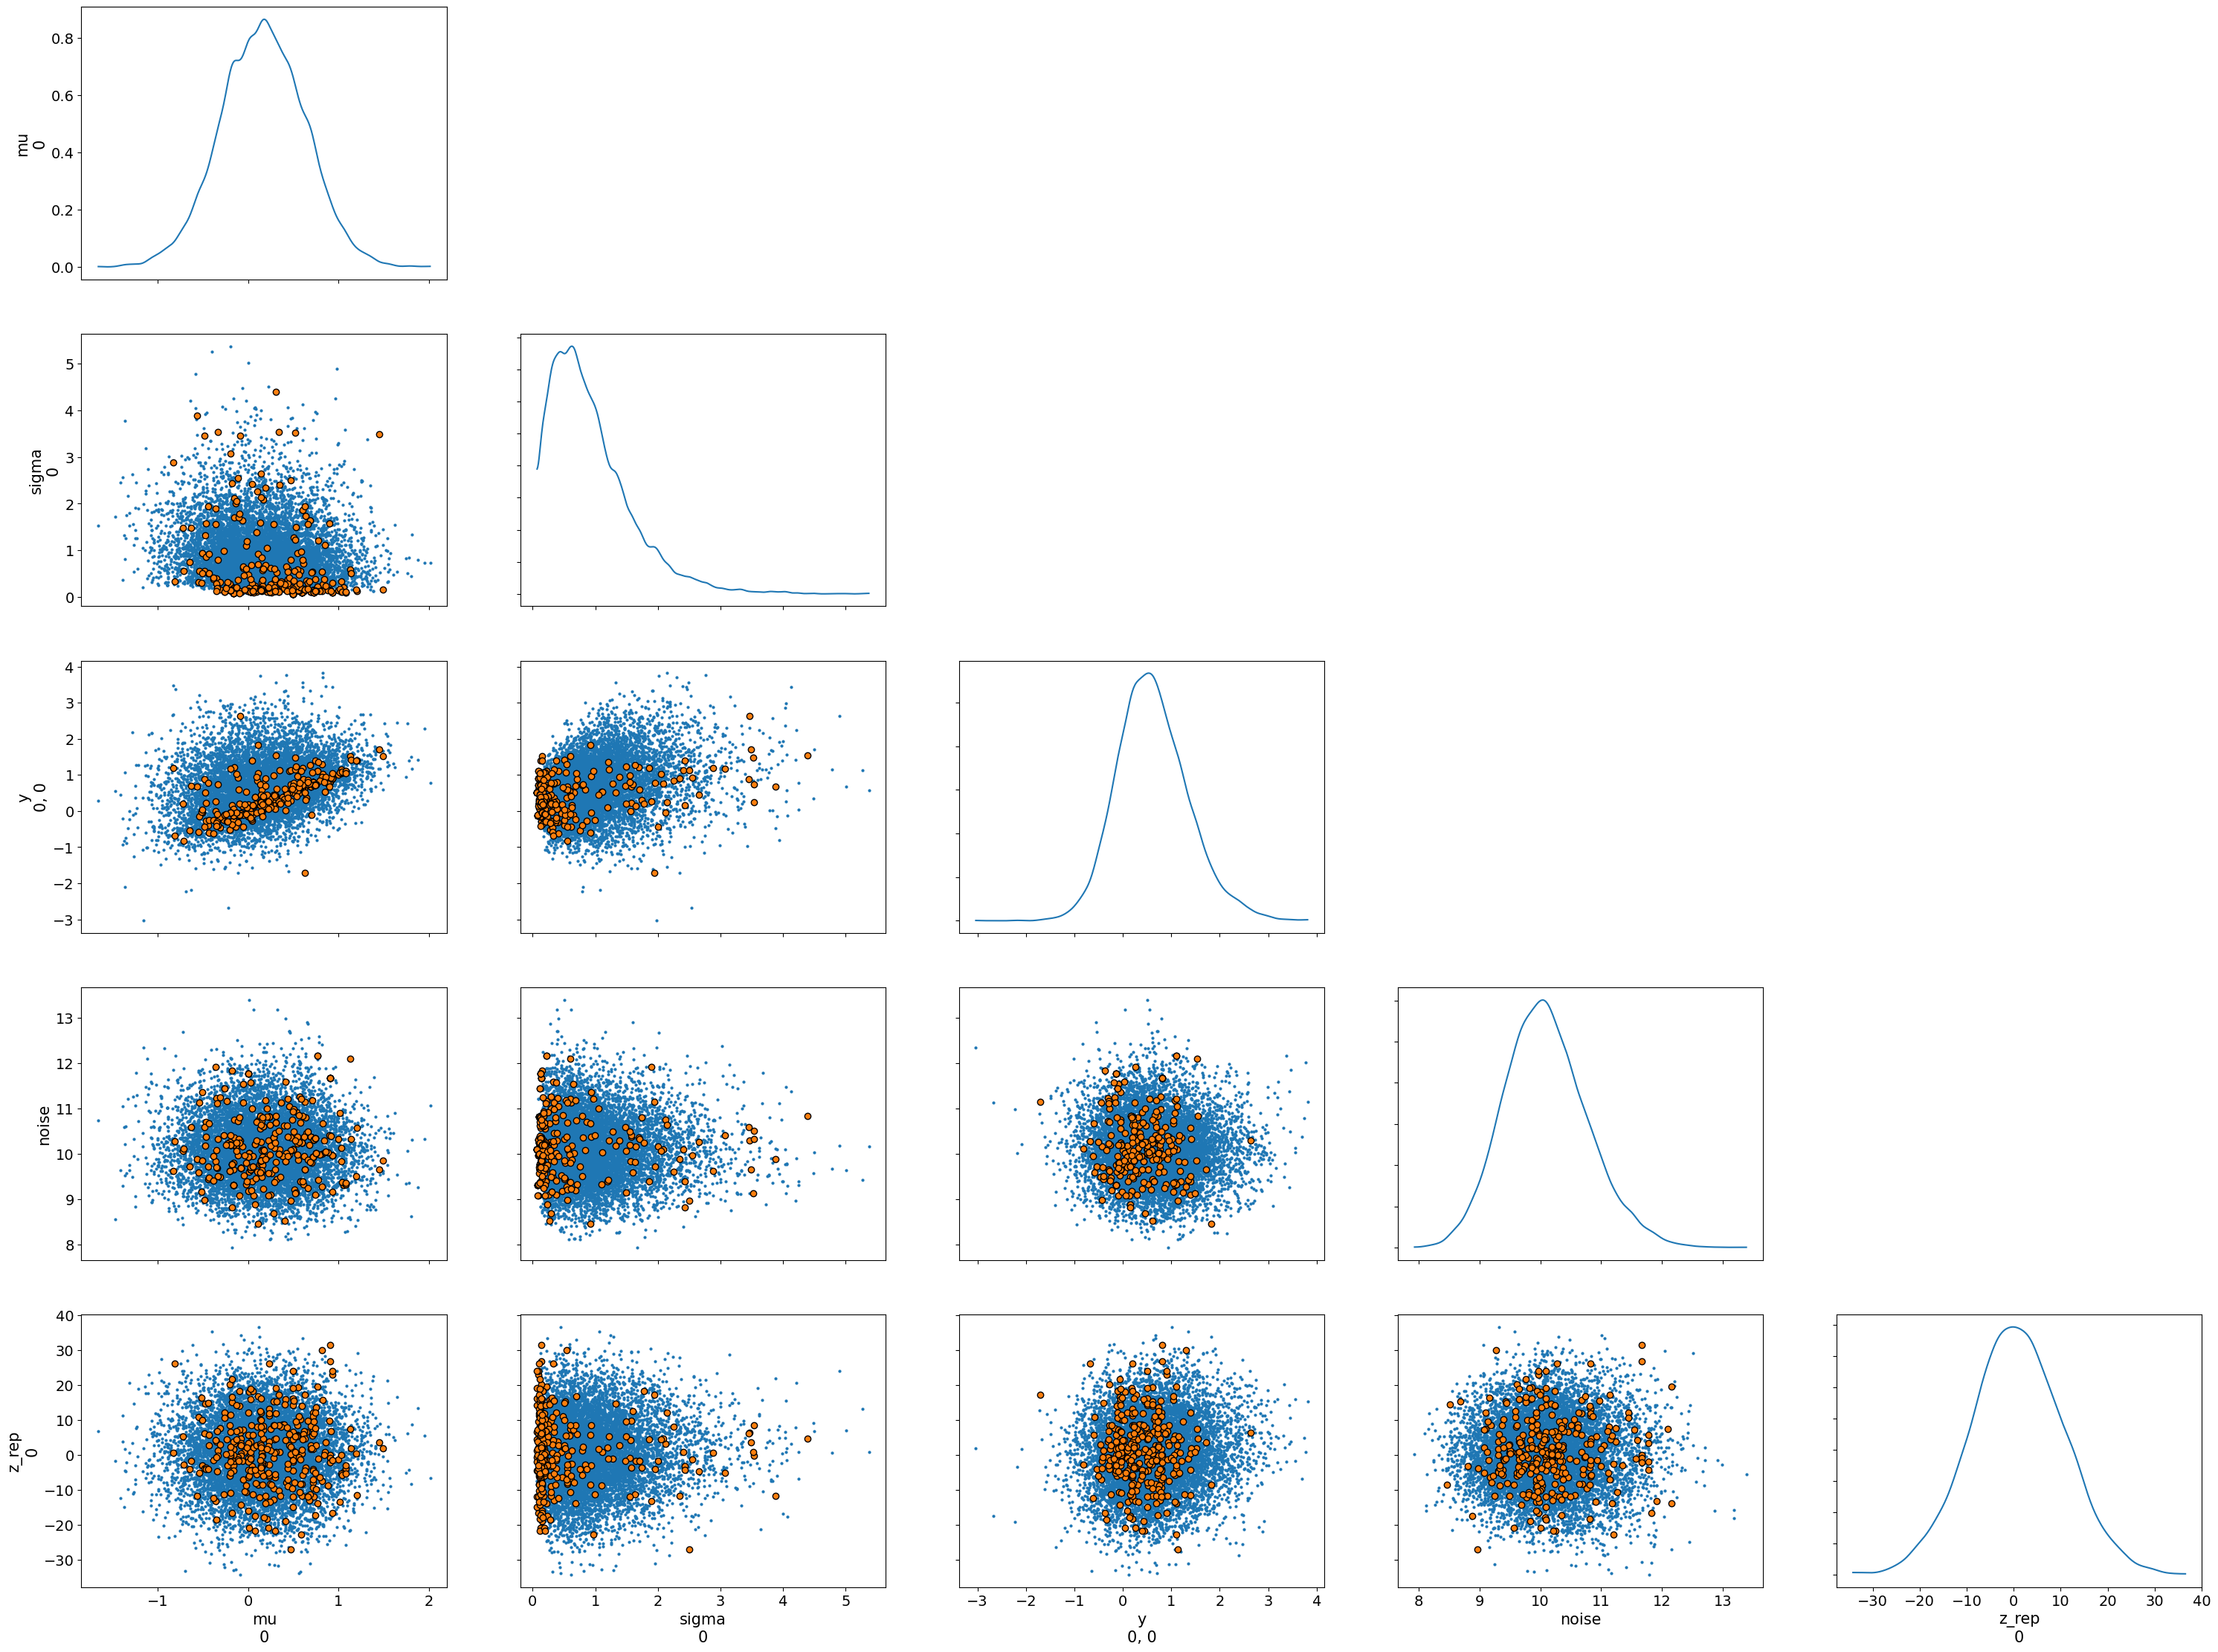

In [68]:
az.plot_pair(cmdstanpy_data, marginals=True, divergences=True)